In [ ]:
from _model import model
import torch
import torch.optim as optim
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data.dataloader import DataLoader
from _utils import utils
from datetime import datetime
now = datetime.now()
from dataset.electricity_dataset import electricity_pre
import _paper_params

In [ ]:
from pandas import read_csv
import pandas
from datetime import datetime
import os
from matplotlib import pyplot

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
def date_cv(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

In [ ]:
dataset = read_csv('dataset/elec.txt', sep=";", decimal=",", header=None, skiprows=[0], parse_dates = [[0]], date_parser=date_cv)
dataset.set_index("0", inplace=True)
weekday = pandas.Series(dataset.index[:].weekday, dtype='int32')
hour = pandas.Series(dataset.index[:].hour, dtype='int32')
minute = pandas.Series(dataset.index[:].minute, dtype='int32')

In [ ]:
dataset.insert(len(dataset.columns), 'weekday', weekday.values)
dataset.insert(len(dataset.columns), 'hour', hour.values)
dataset.insert(len(dataset.columns), 'min', minute.values)
dataset.index.name = 'date'
dataset = dataset[35042:]
print(dataset.head(5))

                            1          2          3           4          5  \
date                                                                         
2012-01-01 00:45:00  3.807107  22.759602  77.324066  140.243902  69.512195   
2012-01-01 01:00:00  3.807107  22.759602  77.324066  140.243902  75.609756   
2012-01-01 01:15:00  5.076142  22.048364  77.324066  146.341463  73.170732   
2012-01-01 01:30:00  3.807107  22.759602  77.324066  134.146341  73.170732   
2012-01-01 01:45:00  3.807107  22.759602  77.324066  132.113821  67.073171   

                              6         7           8          9         10  \
date                                                                          
2012-01-01 00:45:00  348.214286  8.479367  279.461279  75.174825  91.397849   
2012-01-01 01:00:00  339.285714  7.348785  279.461279  68.181818  88.172043   
2012-01-01 01:15:00  342.261905  6.783493  265.993266  69.930070  86.021505   
2012-01-01 01:30:00  336.309524  6.218202  272.727273  66.

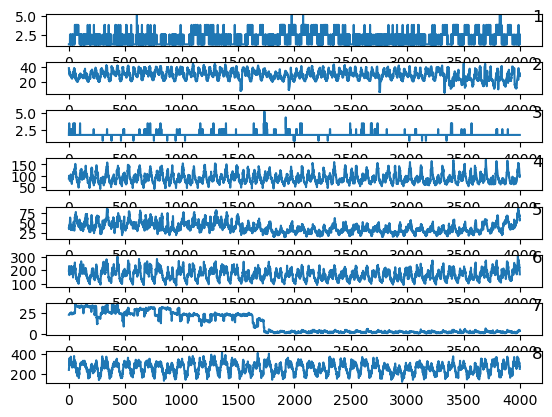

In [ ]:
values = dataset.values
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
fig = pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[20000:24000, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
fig.subplots_adjust(hspace=0.5)
pyplot.show()
dataset.to_csv('dataset/electricity.csv')

In [ ]:
params = _paper_params._params_
dataset = electricity_pre(csv_file=params['data_file'], dev=device, ctx_win_len=params['ctx_win_len'], num_time_indx=params['num_time_idx'])

In [ ]:
num_covariates = params['num_covariates']
num_time_idx = params['num_time_idx']
num_targets = params['num_targets']
input_dim = num_time_idx + num_targets + num_covariates

In [ ]:
ctx_win_len = params['ctx_win_len']
cond_win_len = params['cond_win_len']
pred_win_len = ctx_win_len - cond_win_len - 1
batch_size = params['batch_size']

In [ ]:
model = model(num_lstms=params['num_lstms'], input_dim=input_dim, output_dim=params['num_targets'],hidden_dim=params['hidden_dim']).to(device)
optimizer = optim.Adam(model.parameters(), params['lr'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=params['lr_step_size'], gamma=params['lr_gamma'])

In [ ]:
train_sampler, test_sampler = dataset.get_train_test_samplers(params['train_test_split'])
train_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, shuffle=False, num_workers=0)
test_dataloader = DataLoader(dataset, batch_size=1, sampler=test_sampler,shuffle=False, num_workers=0)
max_batches_per_epoch = params['max_batches_per_epoch']
num_epochs = params['num_epochs']

In [ ]:
losses = []
batch_num = 1
utils = utils(device, params)

def train():
    for epoch in range(0, num_epochs):
        batch_num = 0
        for i, batch in enumerate(train_dataloader):
            if batch_num > max_batches_per_epoch:
                break
            input, target, covariates = utils.split_batch(batch)
            input_cond = input[:, 0:cond_win_len, :]
            input_cond, covariates = utils.scale(input_cond, covariates)
            optimizer.zero_grad()
            out = model(input_cond, covariates, future=pred_win_len)
            out = utils.invert_scale(out, probabalistic=True)
            loss = model.NLL(out, target)
            loss.backward()
            scheduler.step()
            optimizer.step()
            loss = loss.item()
            losses.append(loss)
            print(f"epoch:{epoch} /{num_epochs}| batch:{batch_num}:loss:{loss}")
            batch_num = batch_num + 1
    return model, losses

In [ ]:
def plot_loss(losses):
    plt.figure()
    plt.title('Loss progression')
    plt.xlabel('batch no')
    plt.ylabel('loss')
    plt.plot(np.arange(len(losses)), losses, 'g', linewidth=2.0)
    plt.show()

In [ ]:
def predict(model, num_targets=1):
    test_dataloader_iter = iter(test_dataloader)
    for i in range(0, 1):
        test_batch = next(test_dataloader_iter)
        with torch.no_grad():
            input, target, covariates = utils.split_batch(test_batch)
            input, covariates = utils.scale(input, covariates)
            pred = model(input[:, 0:cond_win_len, :], covariates, future=pred_win_len)
            pred = utils.invert_scale(pred, True)
            loss = model.NLL(pred, target)
            print("loss (prediction): {0}".format(loss))
            preds = pred[0, :, :, :].detach().cpu().numpy()
            targets = target[0, :, :].detach().cpu().numpy()

        for j in range(num_targets):
            pred = preds[:, j, 0]  
            std = preds[:, j, 1]  
            target = targets[:, j]
            plt.figure()
         
            plt.xlabel('x')
            plt.ylabel('y')
            plt.xticks()
            plt.yticks()
            plt.plot(np.arange(len(target)), target, 'r', linewidth=2.0)
            plt.plot(np.arange(cond_win_len), pred[0:cond_win_len], 'b', linewidth=2.0)
            plt.plot(np.arange(cond_win_len, cond_win_len + pred_win_len), pred[cond_win_len:], 'g' + ':',
                     linewidth=2.0)
            plt.fill_between(np.arange(len(target)), pred - std, pred + std, color='cyan', alpha=0.5)
            plt.fill_between(np.arange(len(target)), pred - 2 * std, pred + 2 * std, color='cyan', alpha=0.2)
            plt.savefig(j)

In [ ]:
model, losses = train()

epoch:0 /20| batch:0:loss:5547.65478515625
epoch:0 /20| batch:1:loss:1816.5831298828125
epoch:0 /20| batch:2:loss:31.564502716064453
epoch:0 /20| batch:3:loss:31.212045669555664
epoch:0 /20| batch:4:loss:30.87135124206543
epoch:0 /20| batch:5:loss:30.196422576904297
epoch:0 /20| batch:6:loss:866.2096557617188
epoch:0 /20| batch:7:loss:30.588293075561523
epoch:0 /20| batch:8:loss:1774.5941162109375
epoch:0 /20| batch:9:loss:20782.84375
epoch:0 /20| batch:10:loss:29.64562225341797
epoch:0 /20| batch:11:loss:29.154096603393555
epoch:0 /20| batch:12:loss:29.244733810424805
epoch:0 /20| batch:13:loss:1081.3173828125
epoch:0 /20| batch:14:loss:28.357879638671875
epoch:0 /20| batch:15:loss:28.066429138183594
epoch:0 /20| batch:16:loss:28.379541397094727
epoch:0 /20| batch:17:loss:28.19356346130371
epoch:0 /20| batch:18:loss:28.002126693725586
epoch:0 /20| batch:19:loss:27.69562530517578
epoch:0 /20| batch:20:loss:27.653030395507812
epoch:0 /20| batch:21:loss:724.332763671875
epoch:0 /20| batc

In [ ]:
data='elec'
date_=str(now).replace(" ", "")
model_save_ = f"{data}_epochs{params['num_epochs']}_{ date_ }"
torch.save(model.state_dict(), model_save_+".pth")

loss (prediction): 7.366334915161133


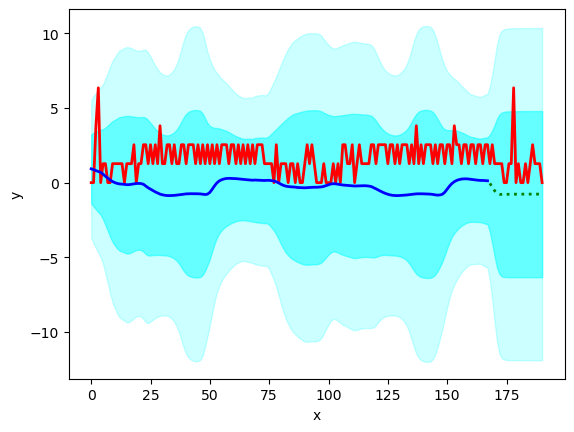

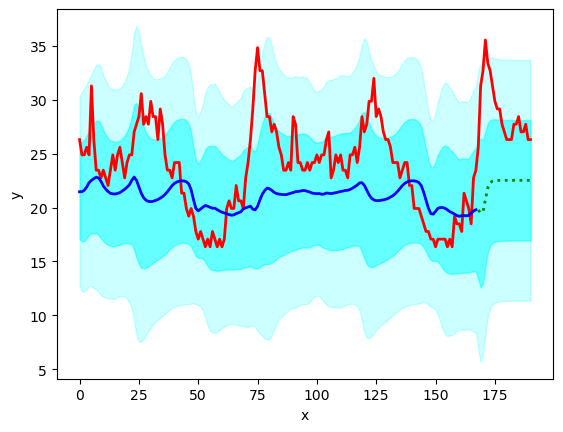

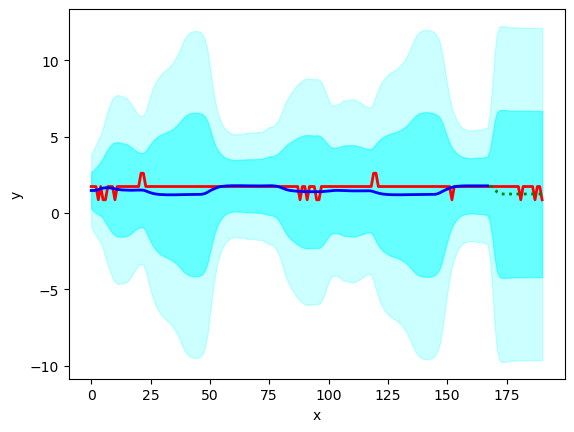

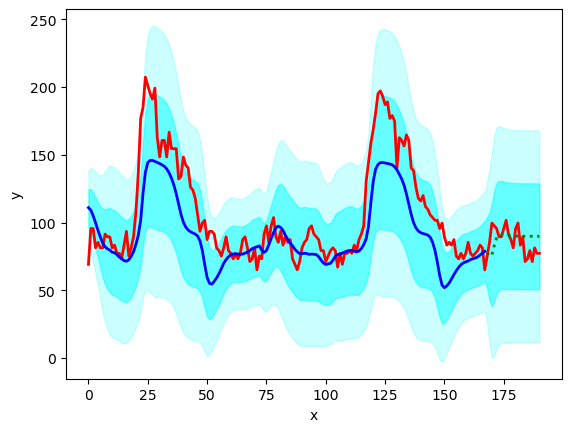

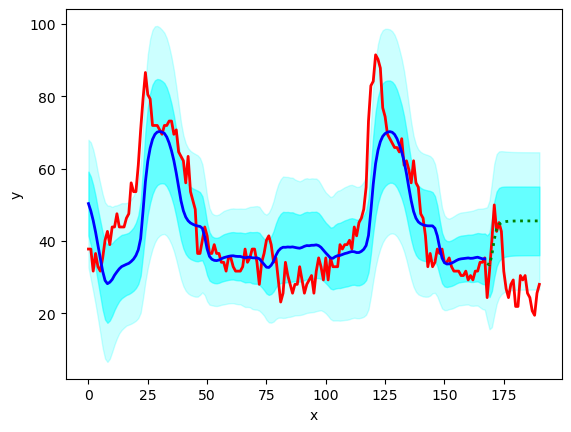

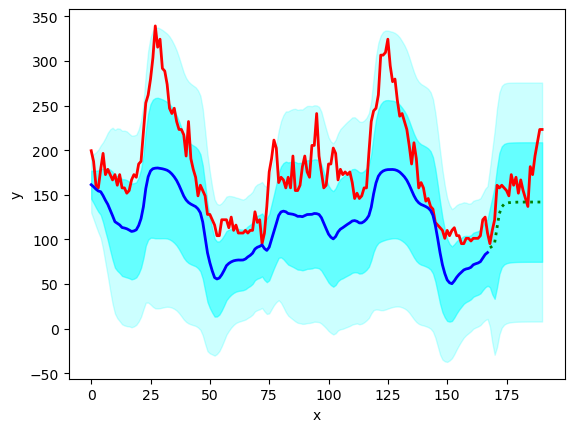

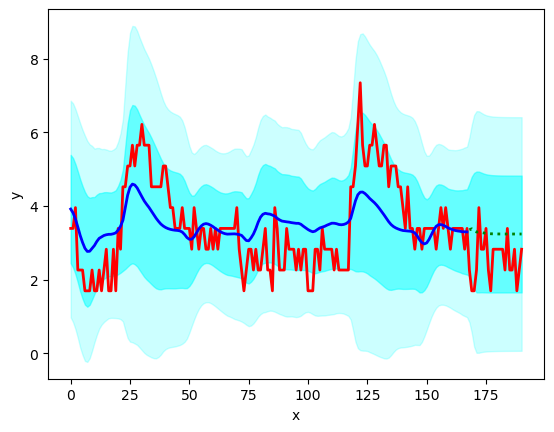

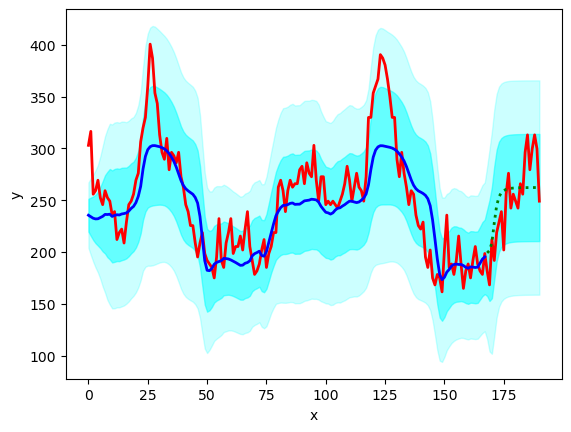

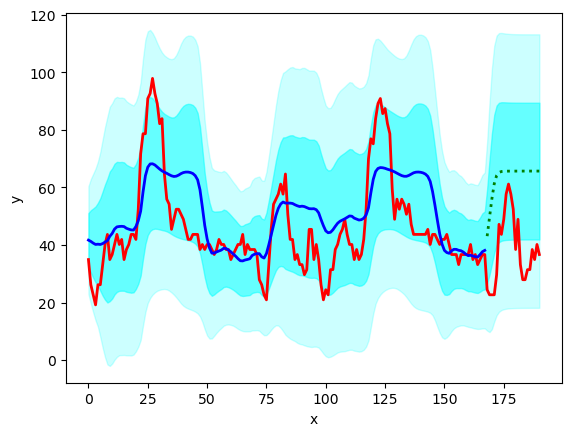

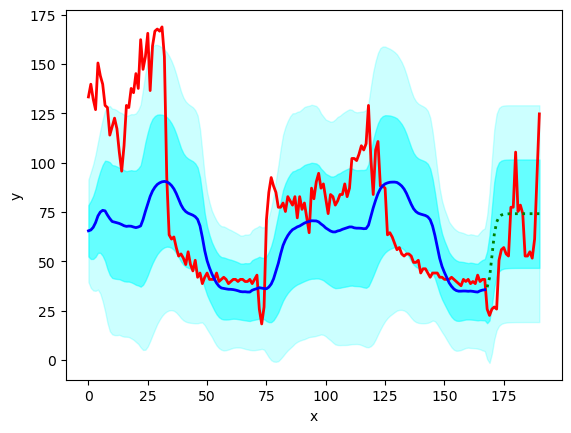

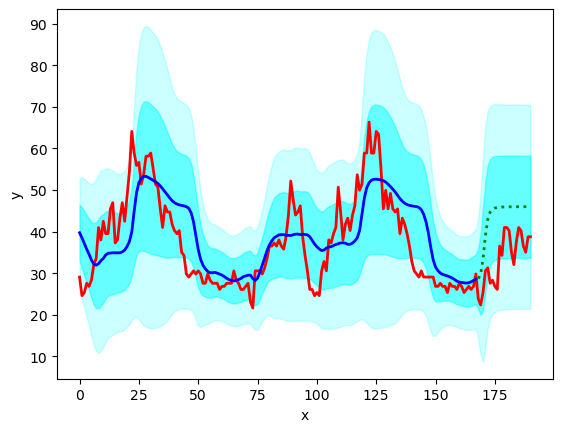

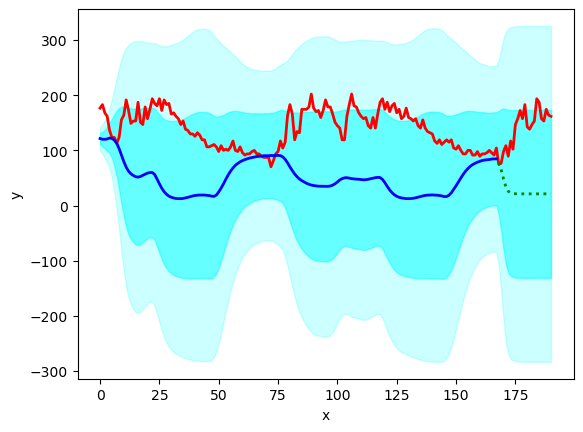

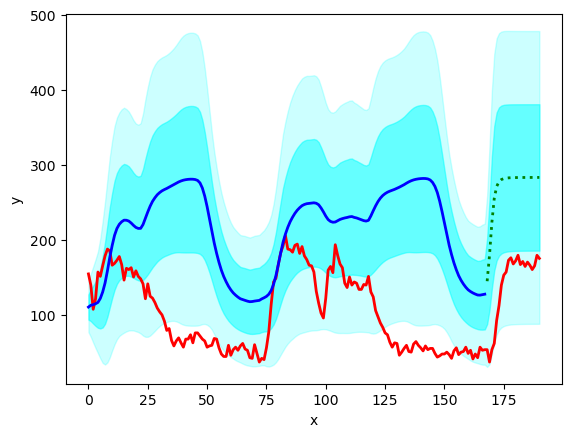

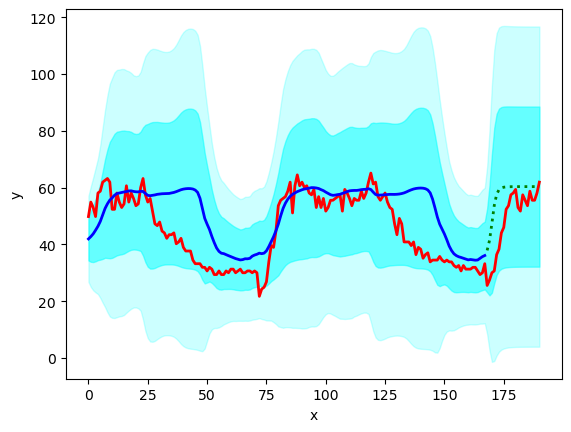

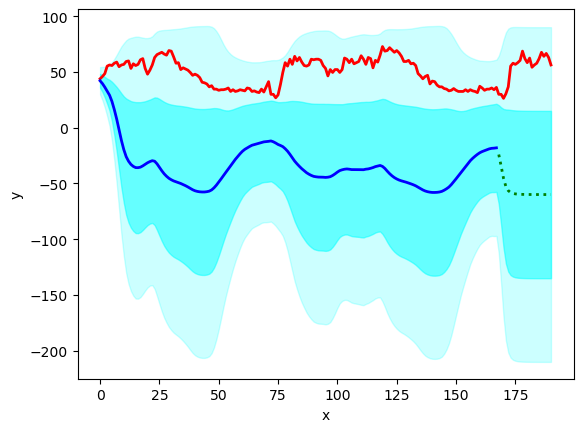

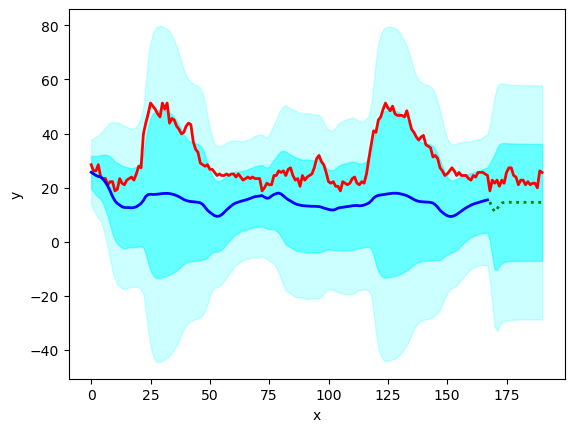

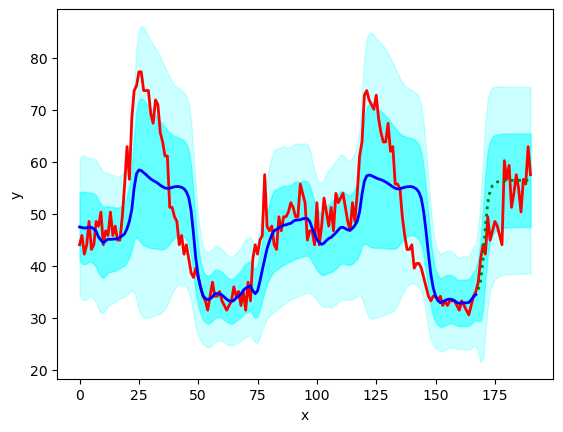

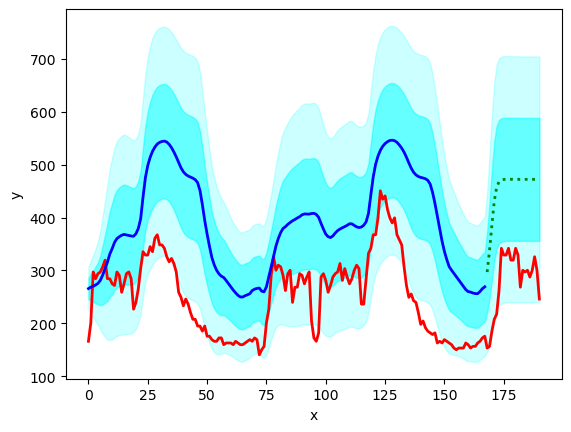

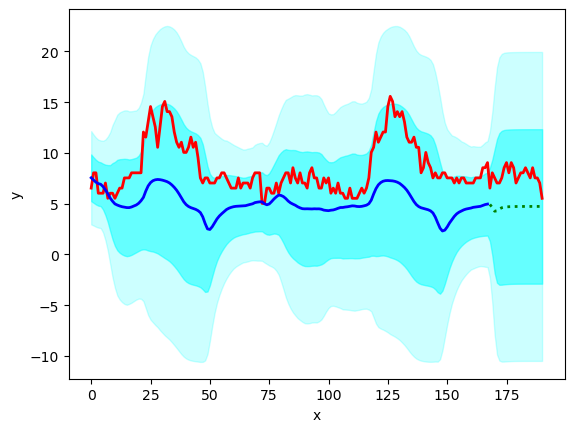

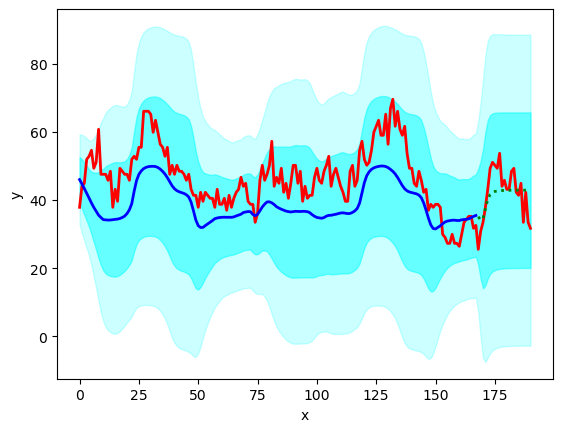

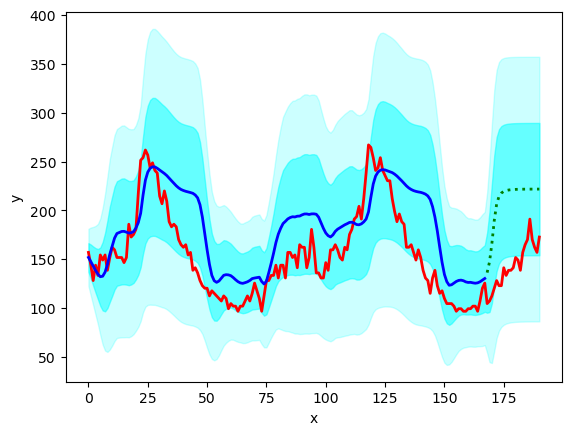

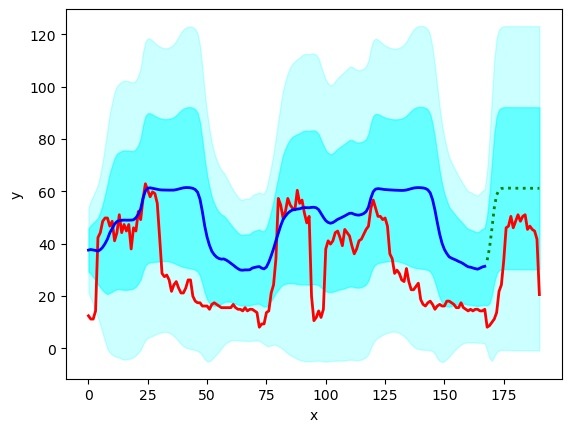

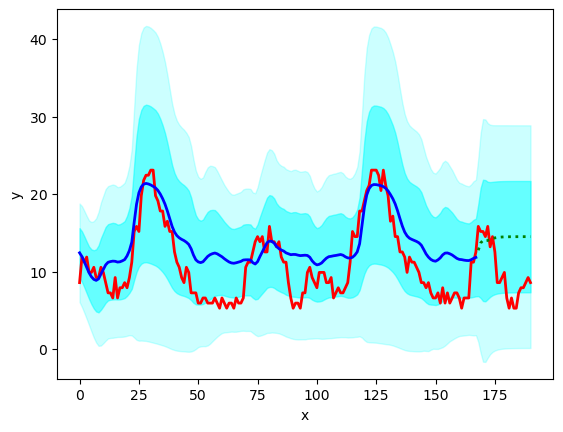

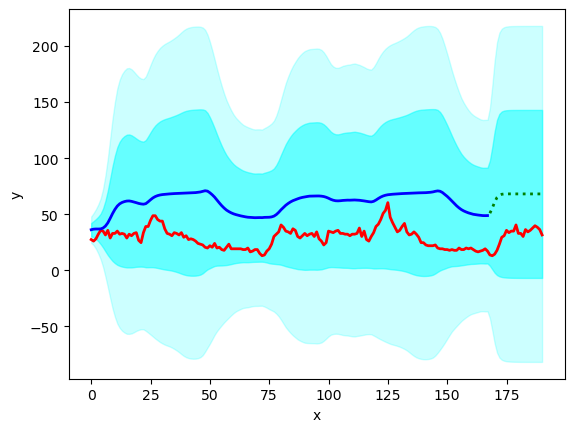

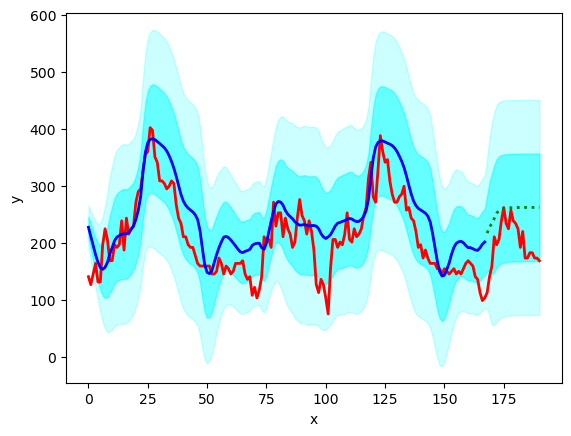

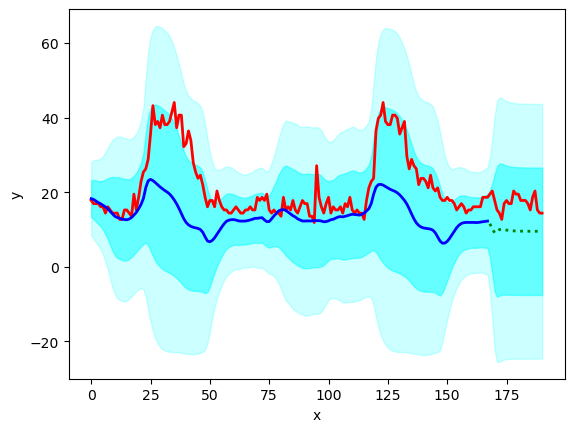

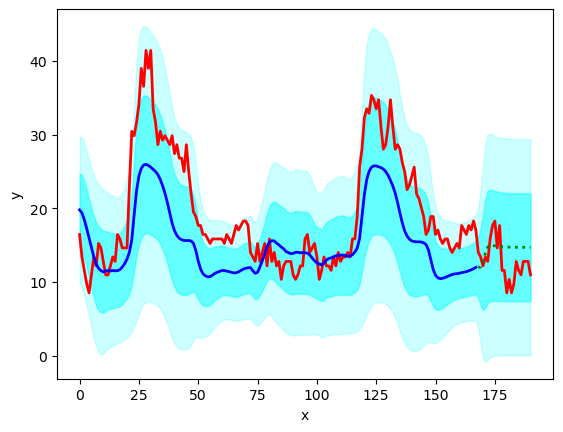

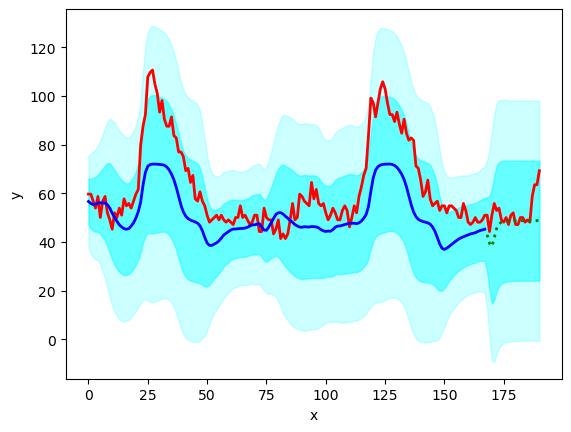

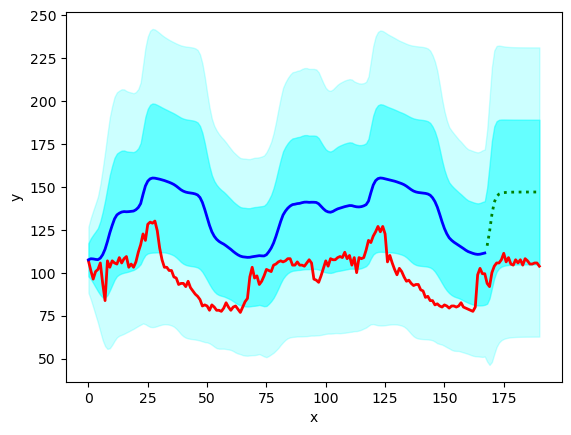

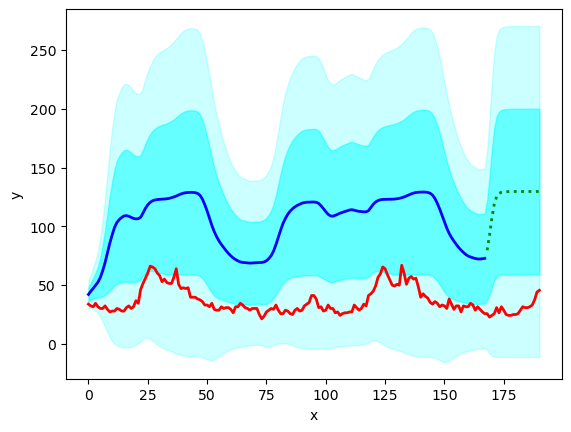

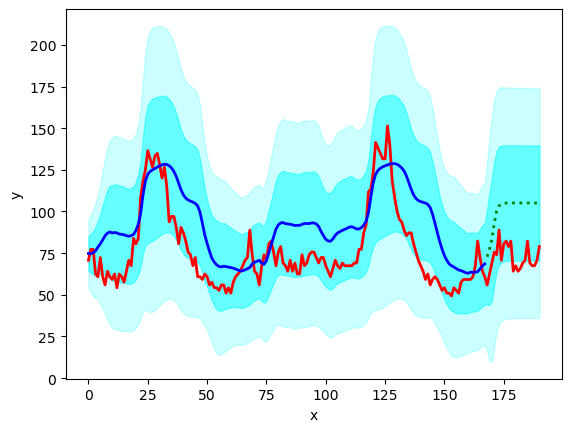

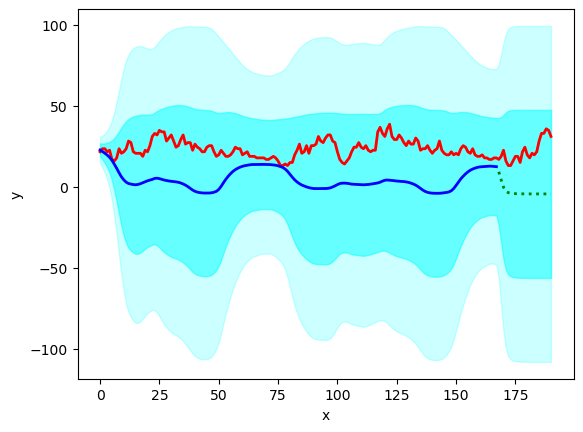

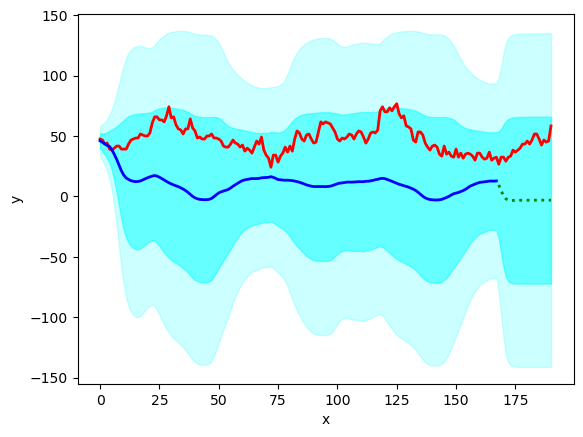

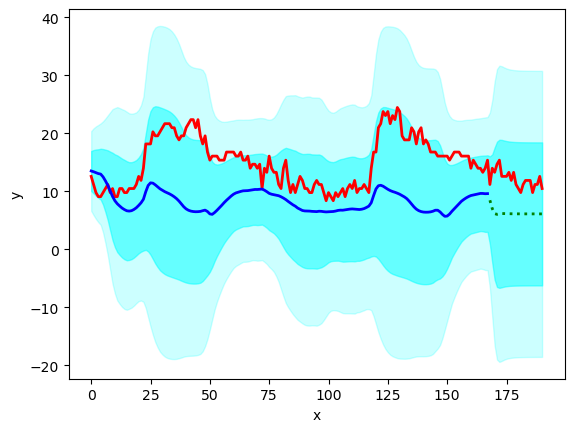

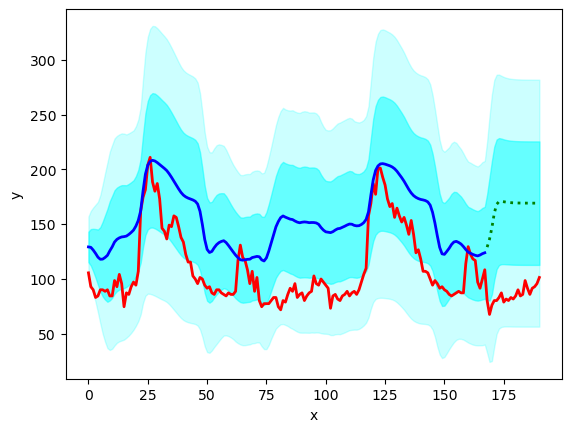

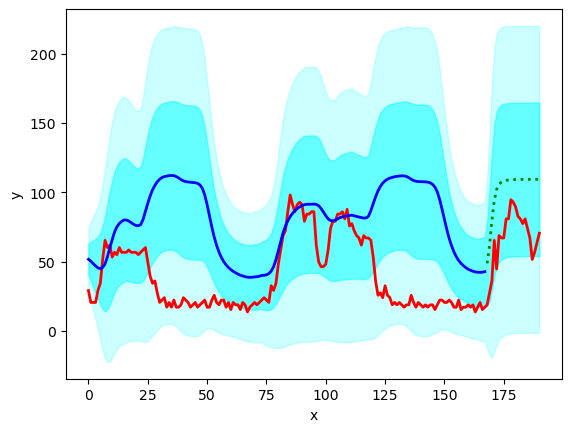

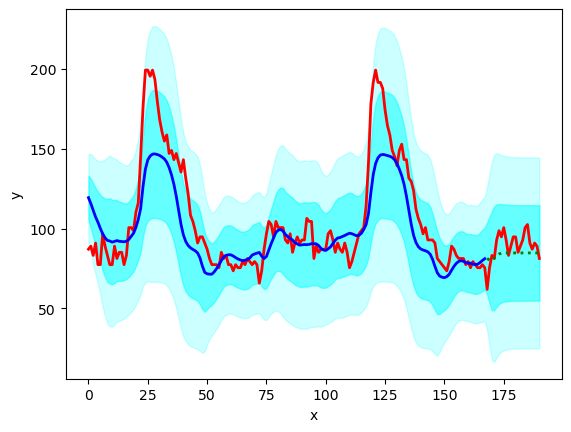

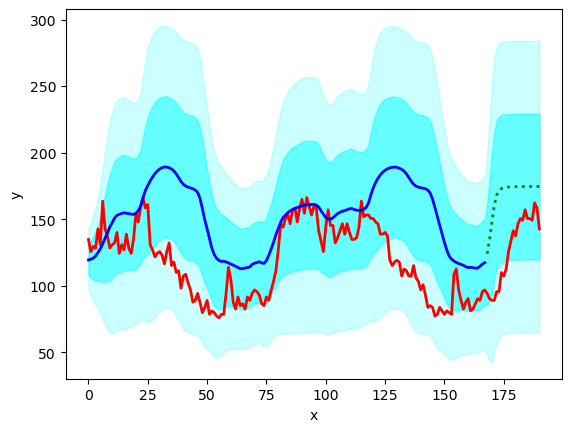

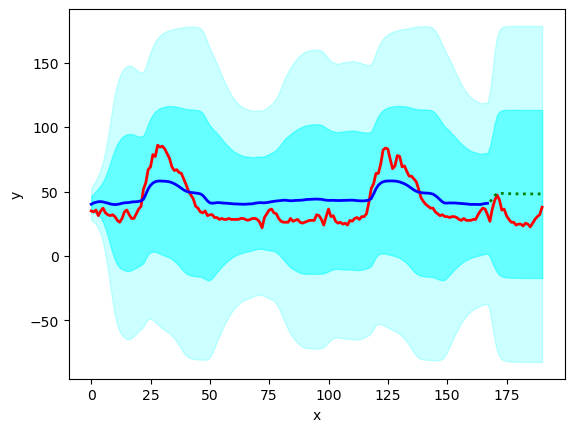

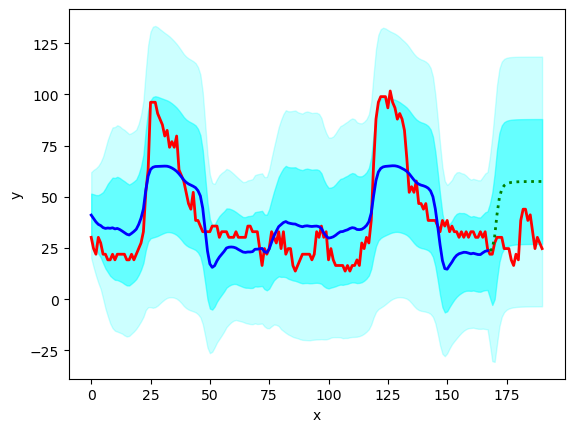

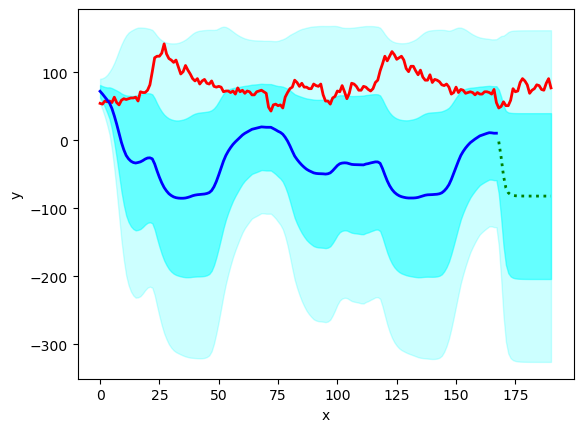

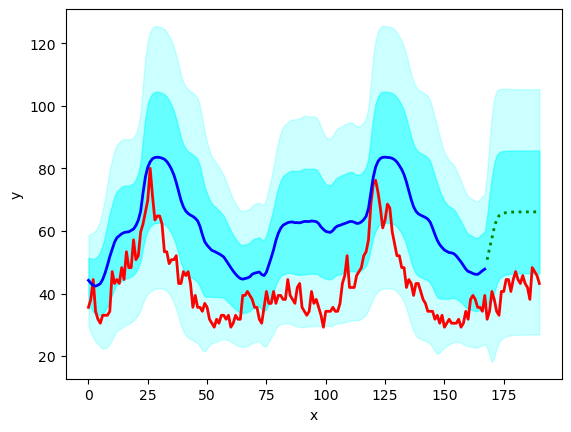

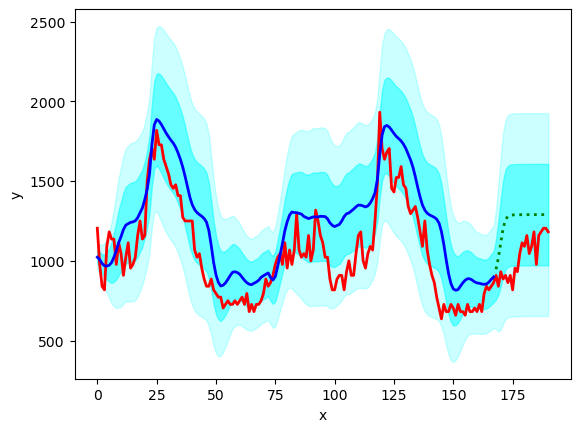

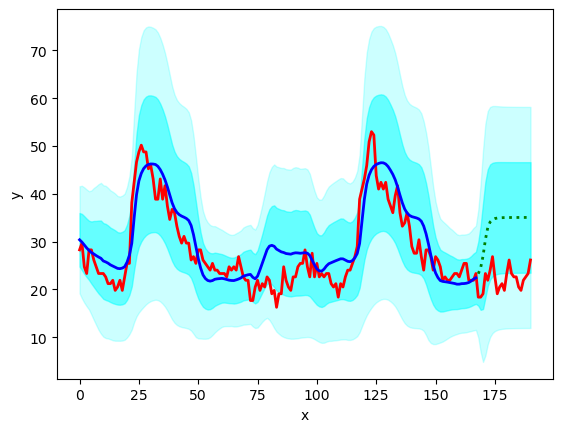

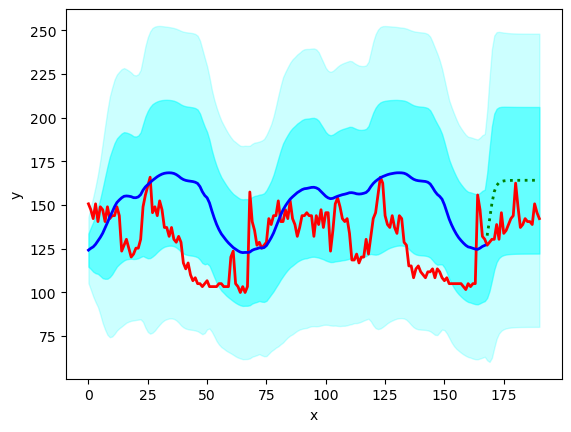

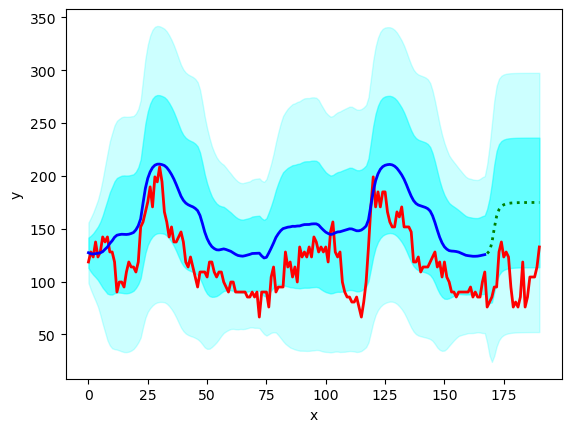

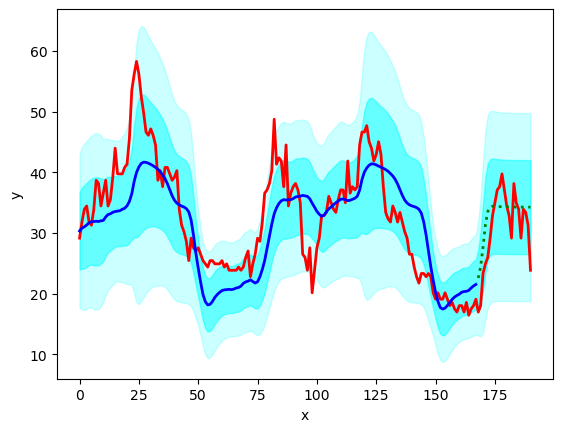

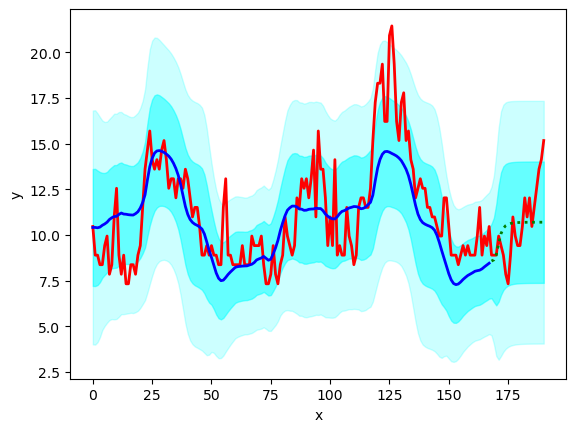

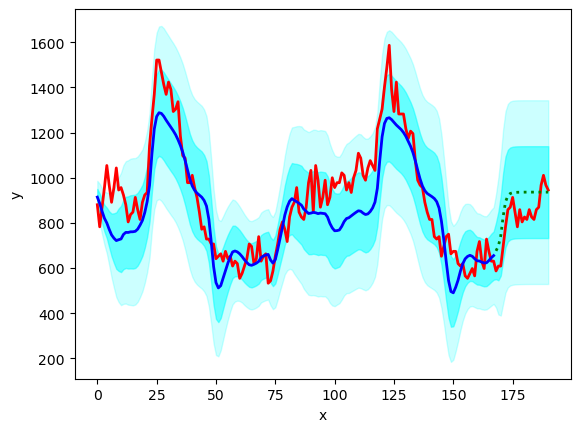

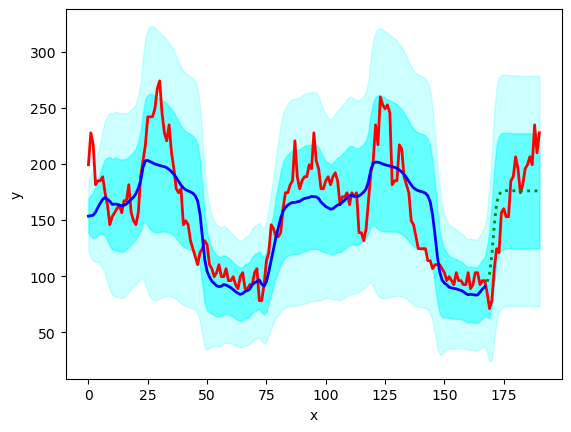

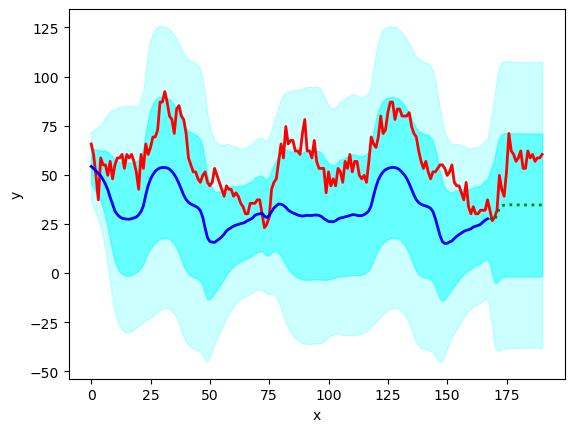

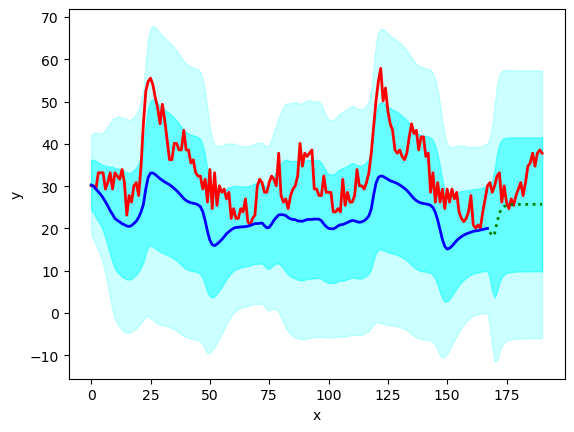

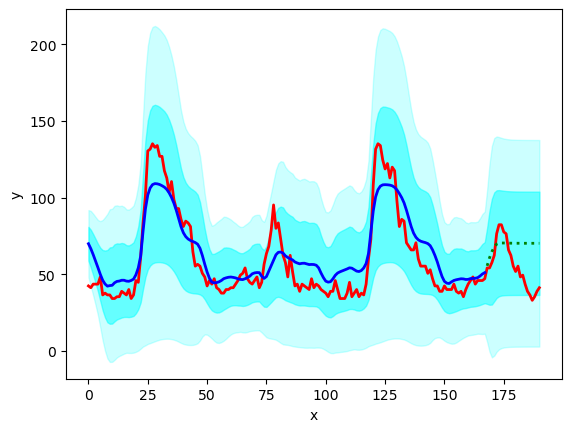

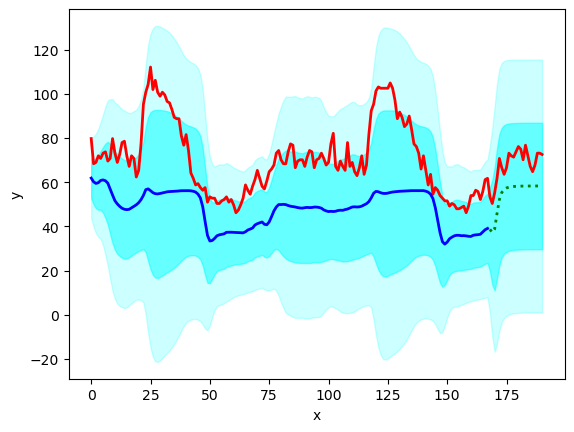

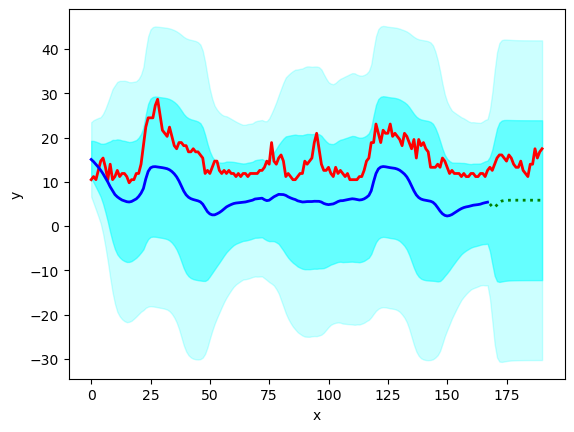

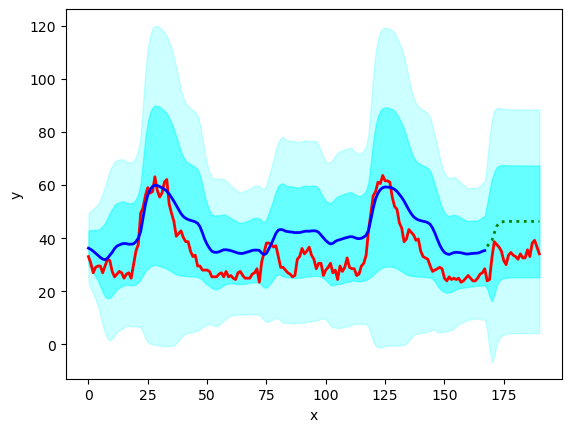

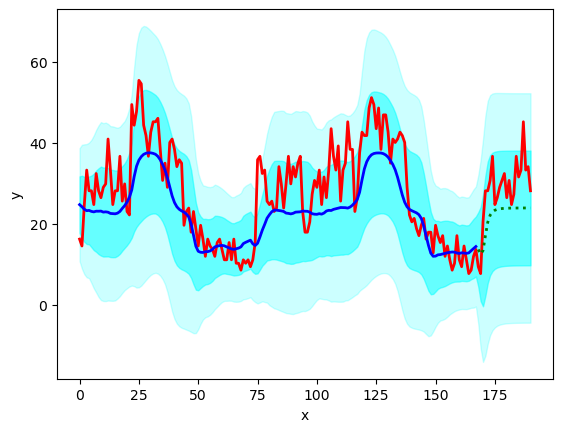

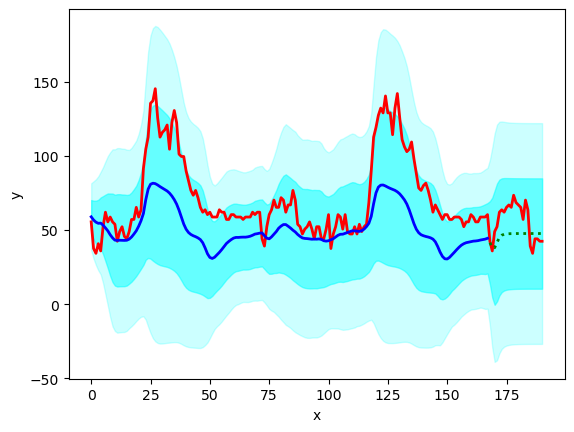

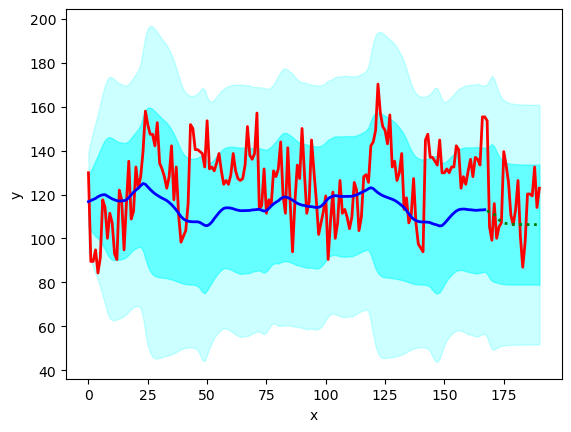

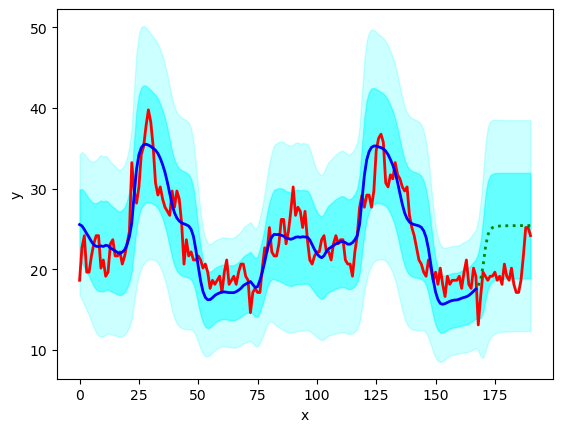

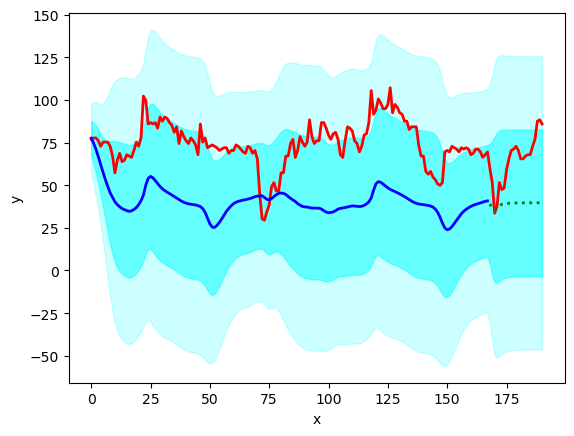

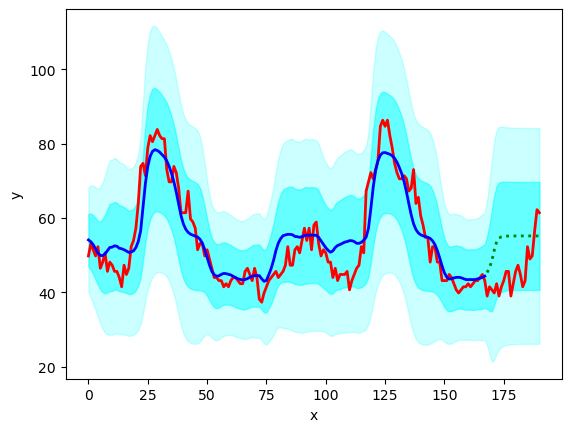

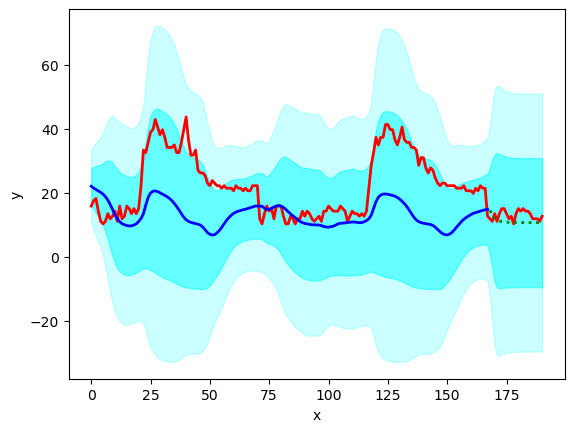

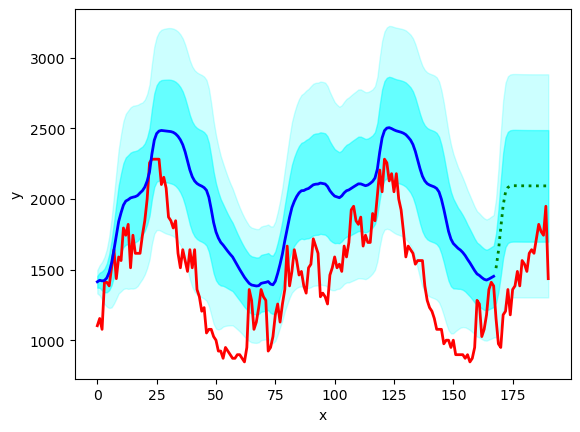

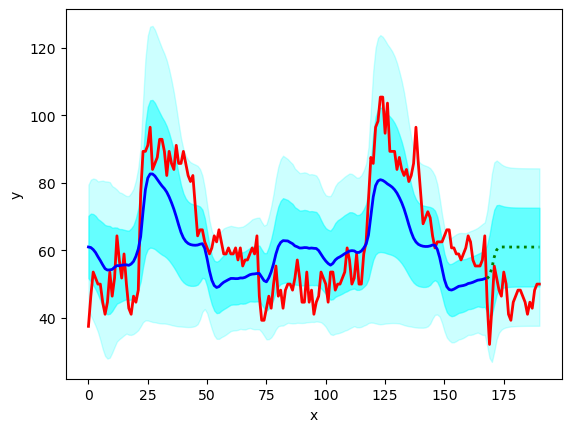

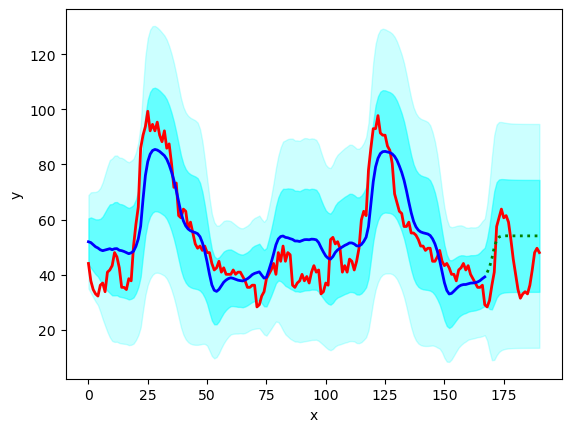

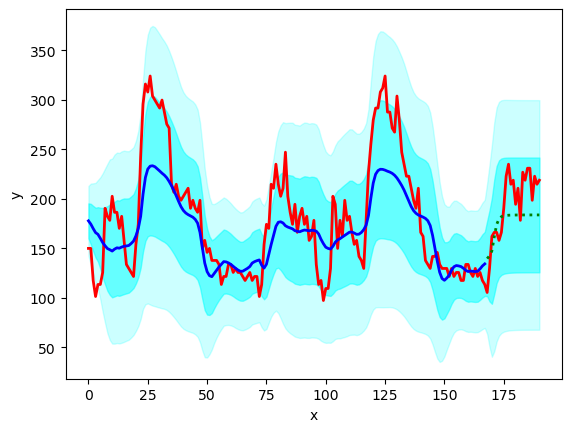

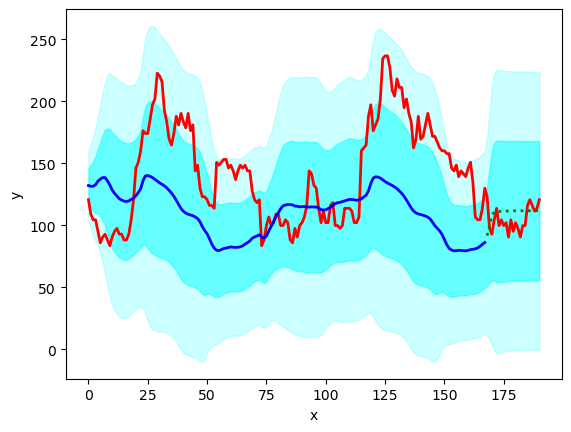

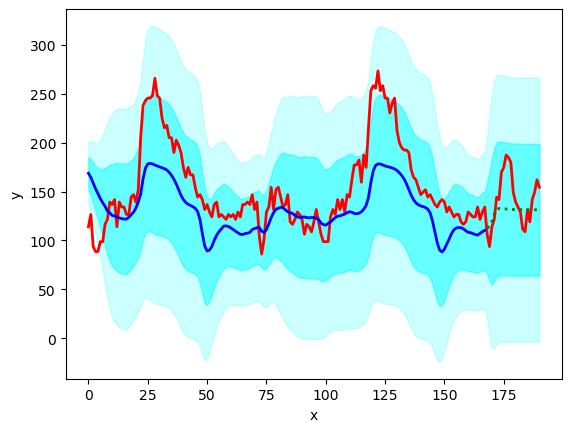

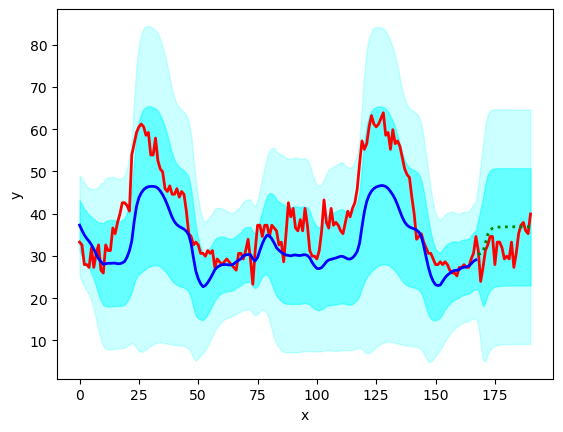

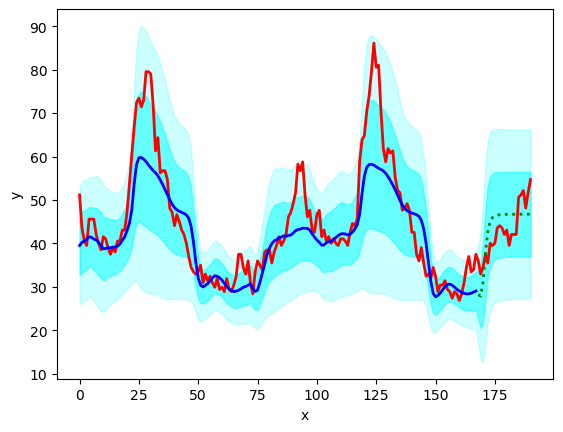

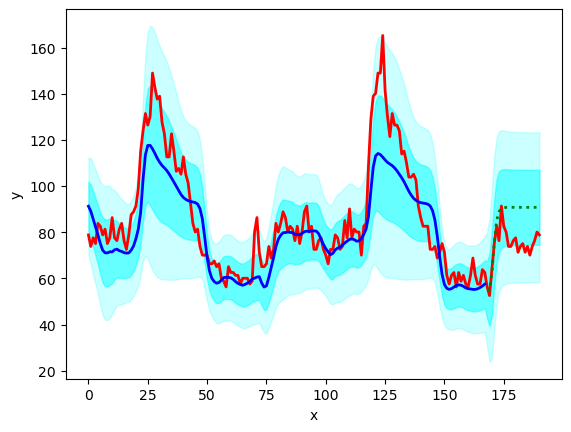

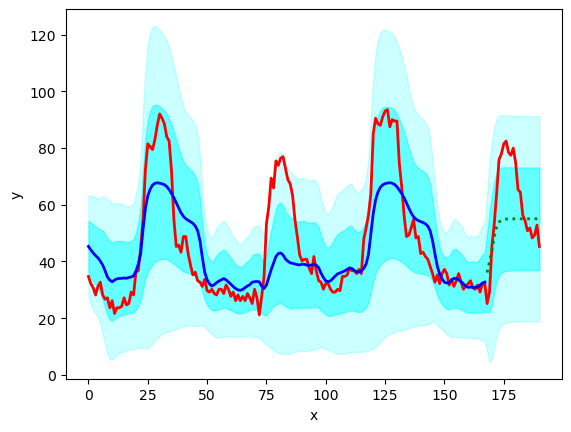

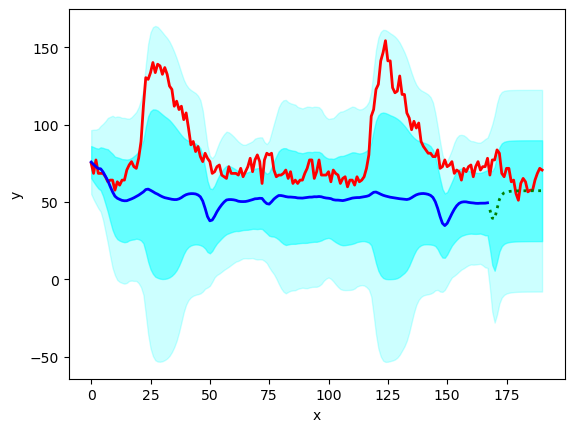

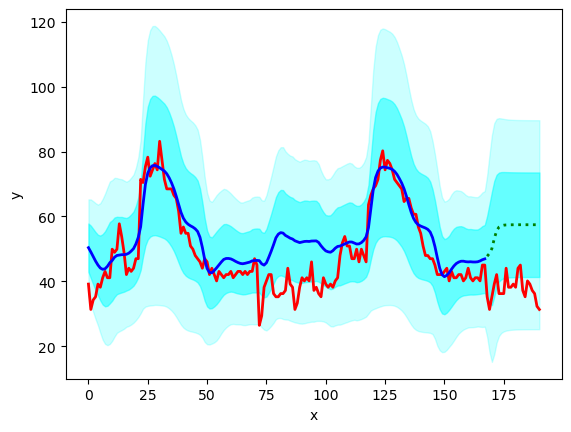

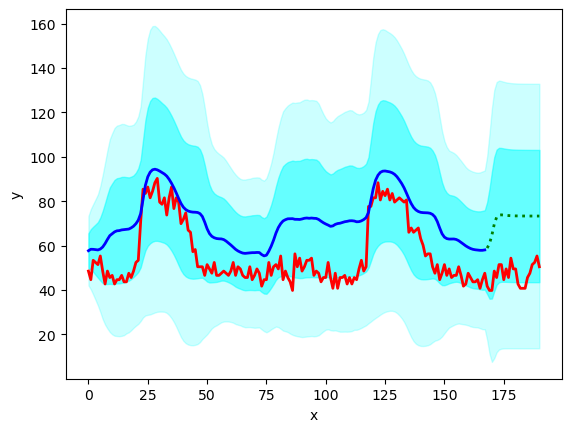

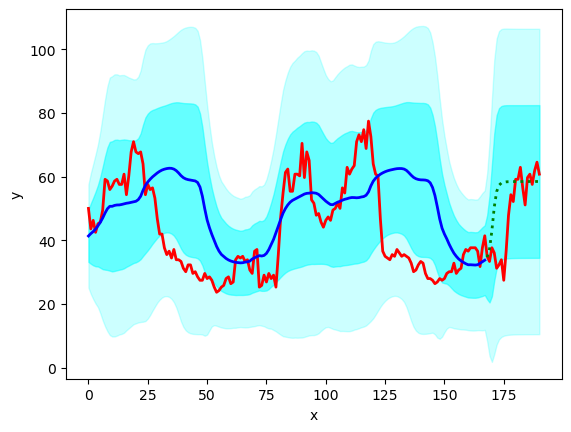

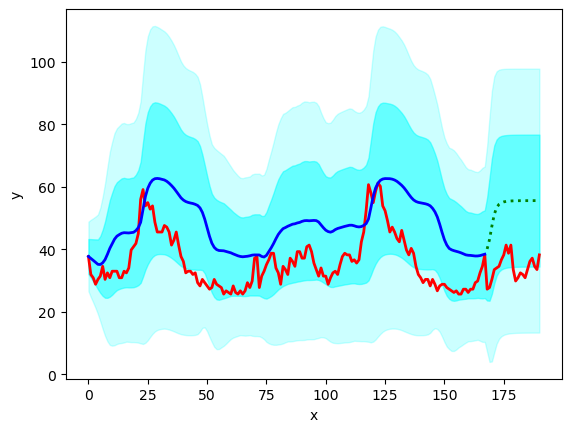

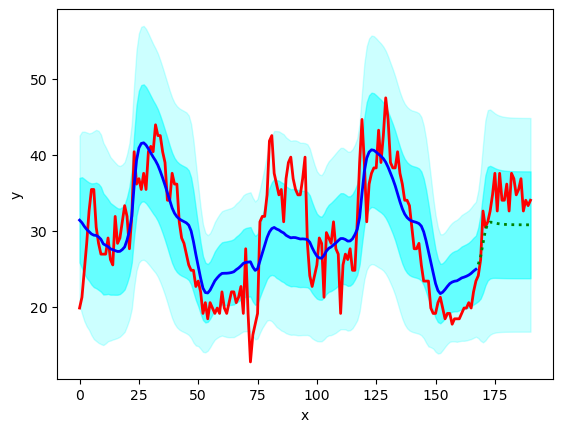

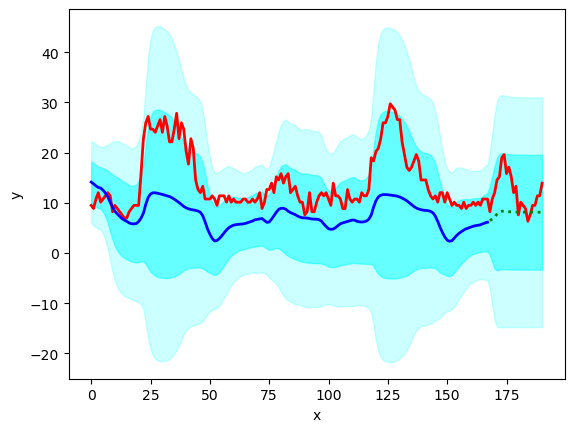

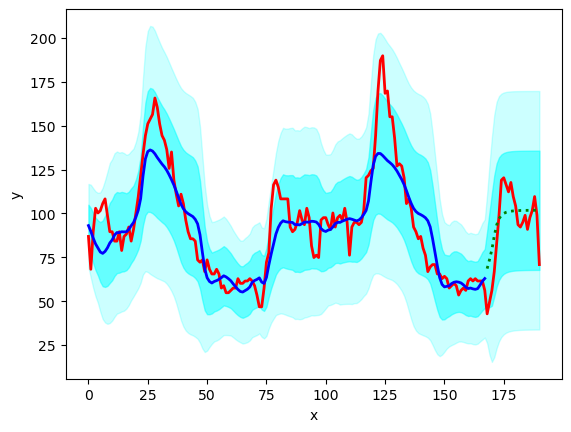

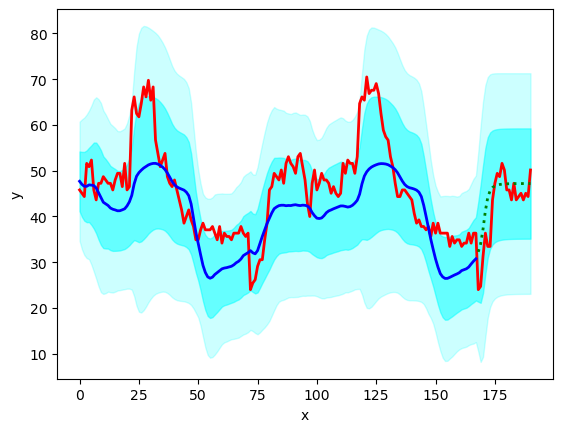

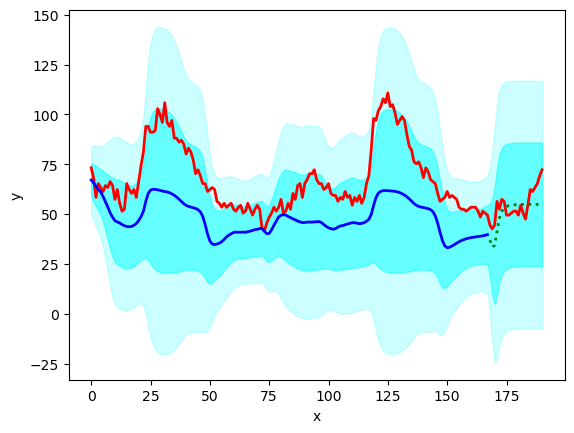

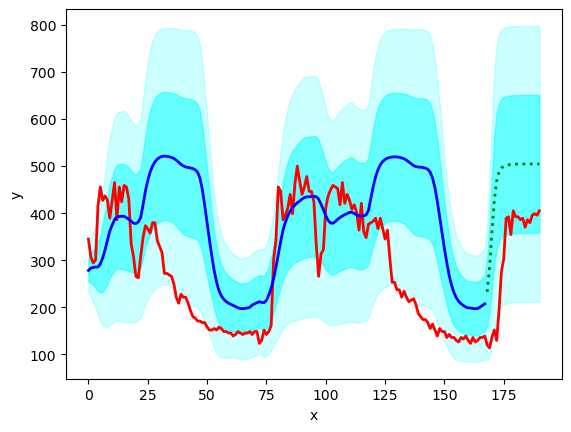

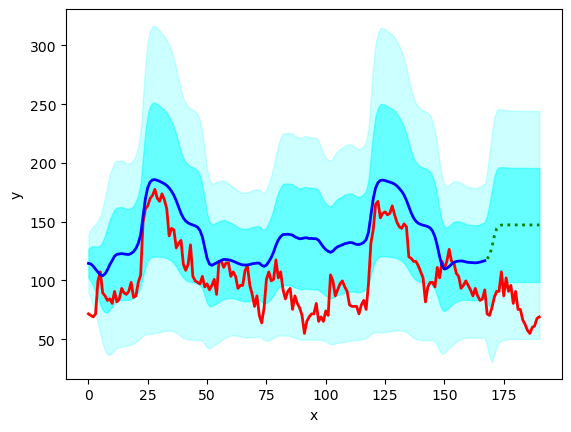

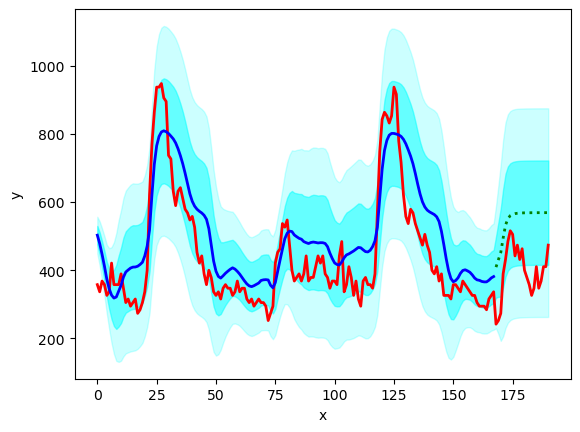

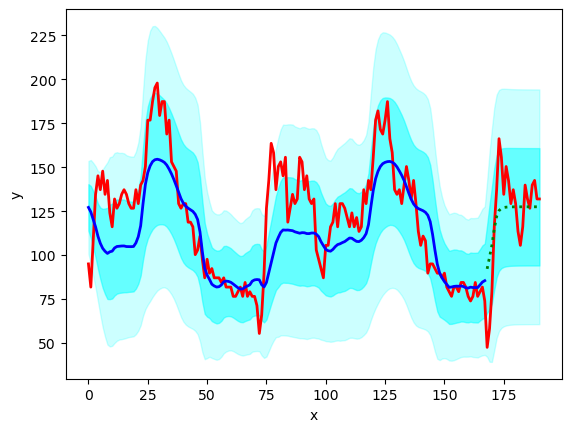

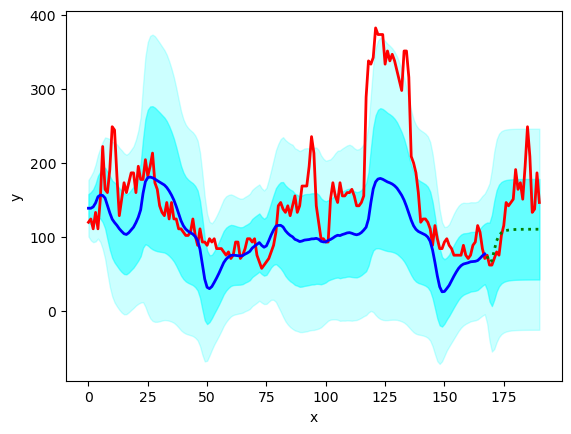

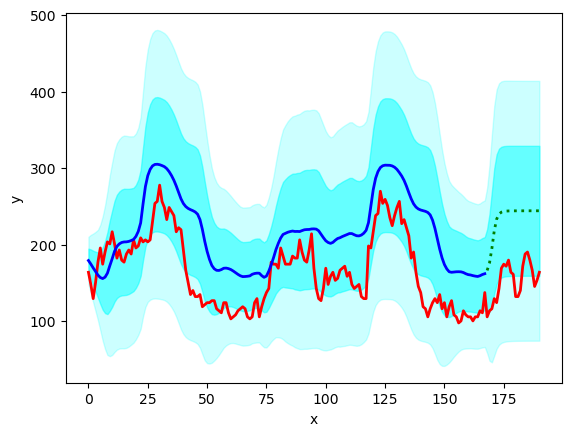

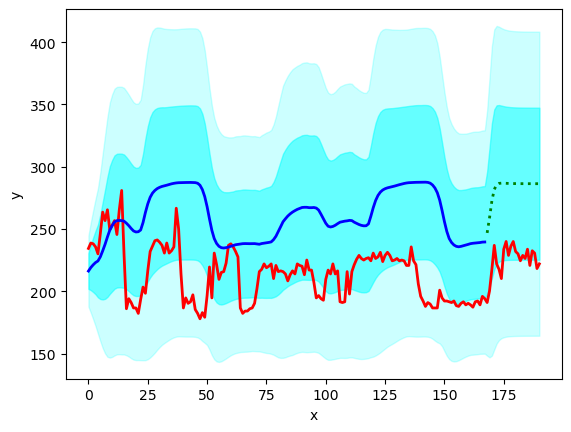

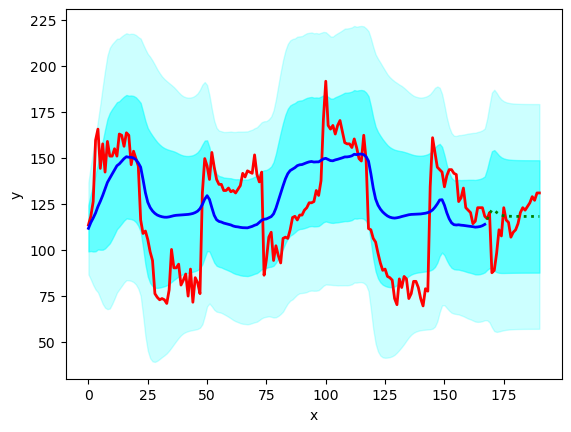

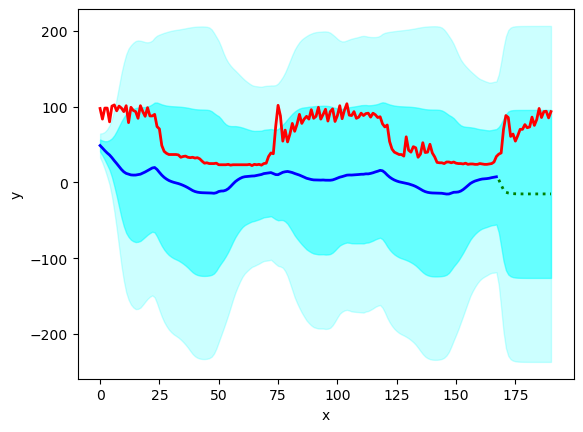

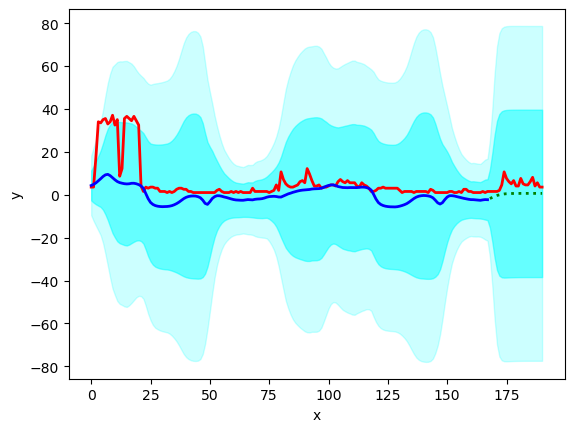

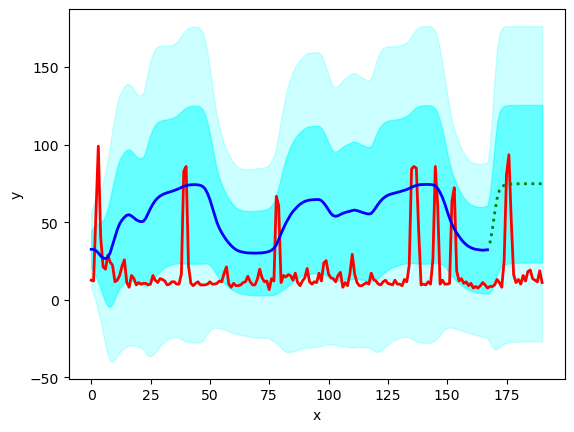

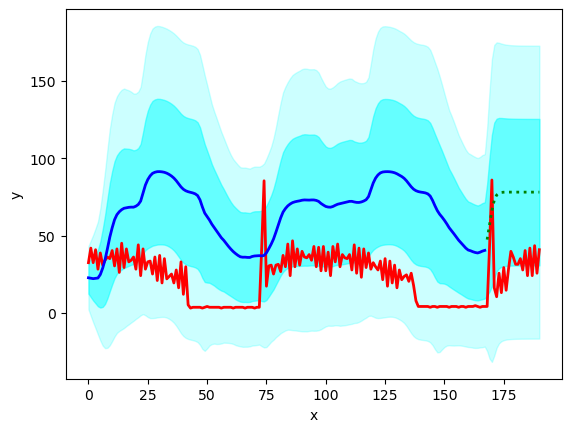

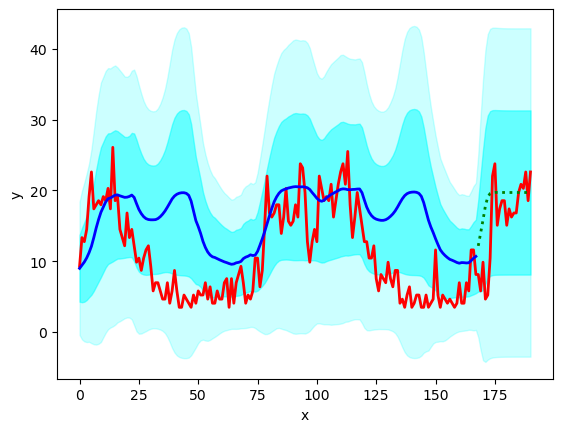

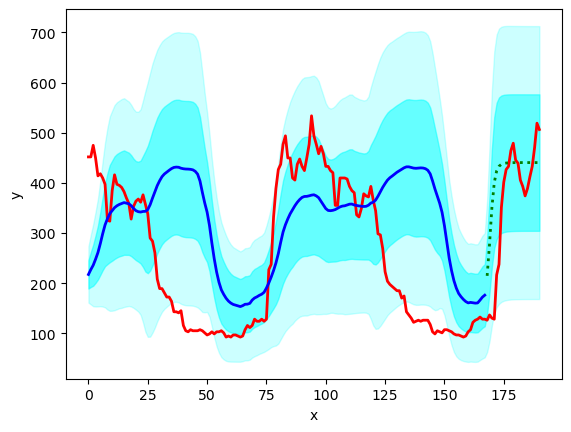

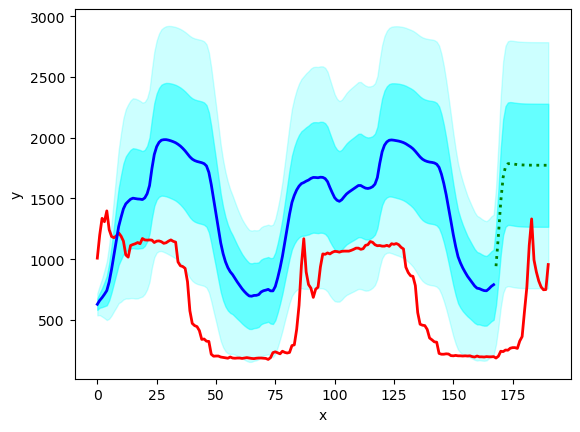

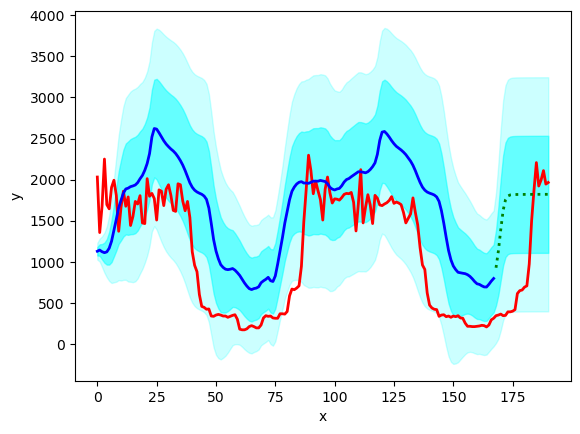

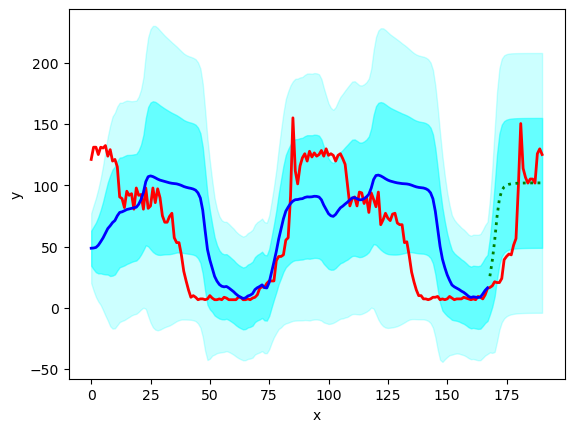

In [ ]:
predict(model, num_targets)